In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [3]:
CAPUCHIN_PATH = 'data/Parsed_Capuchinbird_Clips/'
NOT_CAPUCHIN_PATH = 'data/Parsed_Not_Capuchinbird_Clips/'

In [4]:
def load_wav(filename):
  file_contents = tf.io.read_file(filename)
  wav, sr = tf.audio.decode_wav(file_contents, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  sr = tf.cast(sr, dtype=tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)
  return wav

In [5]:
pos = tf.data.Dataset.list_files(CAPUCHIN_PATH+'*.wav')
neg = tf.data.Dataset.list_files(NOT_CAPUCHIN_PATH+'*.wav')

In [6]:
pos = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
neg = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

In [7]:
data = pos.concatenate(neg)

In [8]:
from glob import glob

lenghts = []
for file in os.listdir('data/Parsed_Capuchinbird_Clips/'):
  tensor_wav = load_wav('data/Parsed_Capuchinbird_Clips/' + file)
  lenghts.append(len(tensor_wav))

In [9]:
tf.math.reduce_min(lenghts)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [10]:
tf.math.reduce_max(lenghts)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [11]:
tf.math.reduce_mean(lenghts)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [12]:
def preprocess(file_path, label): 
    wav = load_wav(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

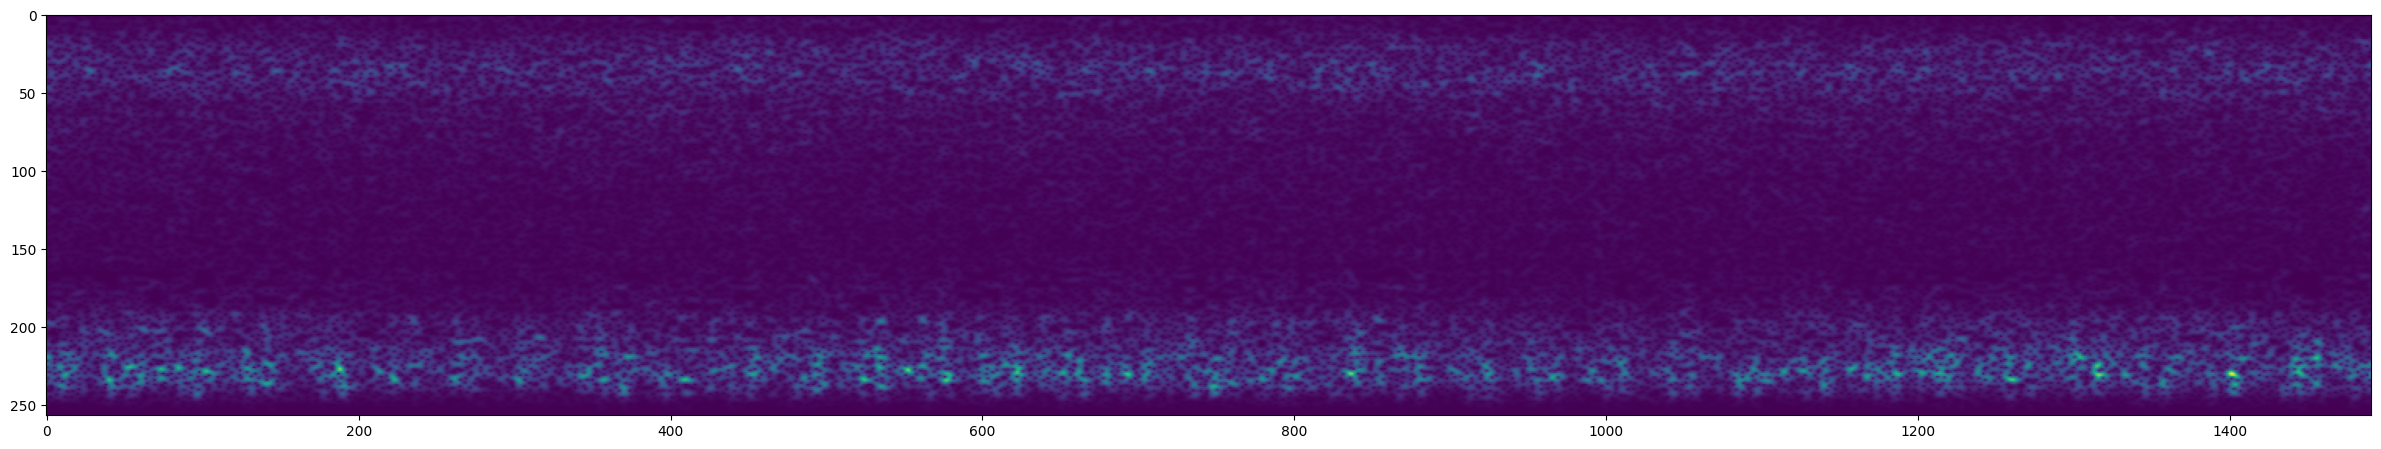

In [13]:
filepath, label = neg.shuffle(buffer_size=1000).as_numpy_iterator().next()
spec, label = preprocess(filepath, label)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spec)[0])
plt.show()

In [14]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [15]:
train = data.take(36)
test = data.skip(36).take(15)

In [16]:
samples, label = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [17]:
label

array([0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [19]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(MaxPool2D())
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 368032)            0         
                                                                 
 dense (Dense)               (None, 128)               4

In [24]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 69s 2s/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 2/4
36/36 [==============================] - 72s 2s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 3/4
36/36 [==============================] - 72s 2s/step - loss: 1.6627e-04 - accuracy: 1.0000 - val_loss: 8.4349e-05 - val_accuracy: 1.0000
Epoch 4/4
36/36 [==============================] - 71s 2s/step - loss: 4.8057e-05 - accuracy: 1.0000 - val_loss: 4.5830e-05 - val_accuracy: 1.0000


In [25]:
def load_mp3(filename):
  res = tfio.audio.AudioIOTensor(filename)
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis=1)/2
  sr = res.rate
  sr = tf.cast(sr, dtype=tf.int64)
  sig = tfio.audio.resample(tensor, rate_in=sr, rate_out=16000)
  return sig

In [26]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [29]:
from itertools import groupby


results = {}

for file in os.listdir('data/Forest Recordings/'):
  sig = load_mp3('data/Forest Recordings/' + file)

  audio_slices = tf.keras.utils.timeseries_dataset_from_array(sig, sig, sequence_length=48000, sequence_stride=48000, batch_size=1)
  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(64)
  yhat = model.predict(audio_slices)

  results[file] = yhat

class_pred = {}
for file, pred in results.items():
  class_pred[file] = [1 if predc>0.99 else 0 for predc in pred]

postprocessed = {}
for file, scores in class_pred.items():
  postprocessed[file] = tf.math.reduce_sum([key for key, groupby in groupby(scores)]).numpy()

postprocessed

1/1 [==============================] - 2s 2s/step


{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 1,
 'recording_16.mp3': 5,
 'recording_17.mp3': 12,
 'recording_18.mp3': 3,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 11,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 13,
 'recording_29.mp3': 0,
 'recording_30.mp3': 1,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 13,
 'recording_39.mp3': 5,
 'recording_40.mp3': 1,
 'recording

In [30]:
import csv

with open('capuchin_results.csv', 'w', newline='') as f:
  writer = csv.writer(f, delimiter=',')
  writer.writerow(['recording', 'capuchin_calls'])
  for key, value in postprocessed.items():
    writer.writerow([key, value])